<a href="https://colab.research.google.com/github/nisharamanna555/ResponsibleDataScience/blob/main/lab_2_fairlearn_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2 & 3 - Decteting and Mitigating Biases using Fairlearn**

**Following Labs:**

*   Lab2: Detecting bias and mitigating bias via pre-processing interventions
*   Lab3: Mitigating bias via in-processing and postprocessing interventions

#Detecting Bias Using Fairlearn

## Bias in ML

A machine learning algorithm will attempt to find patterns, or generalizations, in the training dataset to use when a prediction for a new instance is needed. For example, the model may discover a pattern whereby a person with a salary over \$40,000 and an outstanding debt of less than $5 is very likely to repay a loan.

However, sometimes the patterns that are found and replicated by a model may not be desirable or, even worse, might be illegal. For example, a loan repayment model may determine that age plays a significant role in the prediction of repayment because the training dataset happened to have better repayment for one age group compared to another. This raises two problems: 1) the training dataset may not be representative of the true population of loan applications for all age groups, and 2) even if it is representative, it is illegal (with limited exceptions) to base loan decisions on an applicant's age, regardless of whether this is an accurate basis for prediction based on historical data.

The loan scenario describes an intuitive example of illegal bias. However, not all undesirable biases in machine learning are illegal; it may also exist in more subtle ways. For example, a loan company may want a diverse portfolio of customers across all income levels, and thus, will deem it undesirable if they are making more loans to high income levels over low income levels. Although this is not illegal or unethical, it is undesirable for the company's strategy.

## The `Fairlearn` toolkit

Fairlearn is a toolkit designed to help address this problem with fairness metrics and bias mitigators. Fairness metrics can be used to check for bias in machine learning workflows. Bias mitigators can be used to overcome bias in the workflow to produce a more fair outcome.

As these two examples illustrate, a bias detection and/or mitigation toolkit needs to be tailored to the particular bias of interest. More specifically, we need to define the attribute(s), called protected (or sensitive) attributes of interest: the attribute whose skewness/bias we are trying to detect and mitigate. The term suggests that the system designer should be sensitive to these features when assessing and mitigating group fairness.

Several stages of the machine learning pipeline are susceptible to bias. One useful way to categorize these stages are, intuitively, 'before,' 'during,' and 'after' training a model. These stages are commonly referred to as *pre-processing*, *in-processing*, and *post-processing* (in Fairlearn, in-processing techniques are available in the *reductions* package).

## Fairlearn

In Labs 2 and 3 we will use Fairlearn to detect and mitigate bias in a classifier. We will use the [ACS PUMS files](https://www.census.gov/programs-surveys/acs/microdata.html), particularly a fraction of the ACS Income dataset, and train a classifier to predict whether an individual has a salary greater than $50K. The protected attribute will be the sex of the individual.

In this Lab 2 notebook, we will:

1. Load the dataset and conduct basic data exploration and preprocessing
2. Explore possible fairness metrics
3. Train a logistic regression classifier and evaluate the fairness of this classifier
4. Train other logistic regression classifiers with pre-processing interventions and re-evaluate fairness
5. Compare the results obtained in 3 and 4

#1. Import Statements
First, we install Fairlearn and import the necessary packages

In [ ]:
%%capture
#@markdown

!pip install fairlearn
!pip install folktables
!pip install matplotlib==3.4.1 --force-reinstall

#ask Lucas if superquail is needed
!git clone https://github.com/lurosenb/superquail

In [ ]:
#@markdown
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
import matplotlib.ticker as ticker

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

from IPython.display import clear_output

#2. Load Data, Conduct Exploratory Analysis, and Preprocess Data
Next, we will load the Folktables dataset.  The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as-is for the following analyses.

For more information on the this dataset, please see the following paper: https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [ ]:
#@markdown Read in the folktables dataset
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)

print(full_df.shape)
full_df.head()

(70000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,43.0,3.0,18.0,1.0,2100.0,6.0,0.0,40.0,2.0,1.0,0.0
1,56.0,1.0,21.0,5.0,4030.0,39.0,0.0,30.0,2.0,2.0,0.0
2,40.0,3.0,24.0,3.0,2310.0,53.0,0.0,40.0,2.0,1.0,1.0
3,60.0,6.0,1.0,2.0,4251.0,303.0,0.0,40.0,1.0,1.0,0.0
4,36.0,1.0,21.0,1.0,1541.0,6.0,1.0,50.0,1.0,1.0,1.0


In [ ]:
#@markdown Check missing values and data types
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  float64
 2   SCHL    70000 non-null  float64
 3   MAR     70000 non-null  float64
 4   OCCP    70000 non-null  float64
 5   POBP    70000 non-null  float64
 6   RELP    70000 non-null  float64
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  float64
 9   RAC1P   70000 non-null  float64
 10  PINCP   70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


In [ ]:
#@markdown Change data types of categorical features
numerical_cols = ['AGEP','WKHP']
categorical_cols = ['COW','SCHL','MAR','OCCP','POBP','RELP','RAC1P','SEX']

for col in categorical_cols:
  full_df[col] = full_df[col].astype('int')
  full_df[col] = full_df[col].astype('str')

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  object 
 2   SCHL    70000 non-null  object 
 3   MAR     70000 non-null  object 
 4   OCCP    70000 non-null  object 
 5   POBP    70000 non-null  object 
 6   RELP    70000 non-null  object 
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  object 
 9   RAC1P   70000 non-null  object 
 10  PINCP   70000 non-null  float64
dtypes: float64(3), object(8)
memory usage: 5.9+ MB


Next, we will conduct some basic exploratory analysis of the data beginning with plotting the distributions of our features.

<ipython-input-6-e594a9aa6ce7>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,2].set_yticklabels(labels)


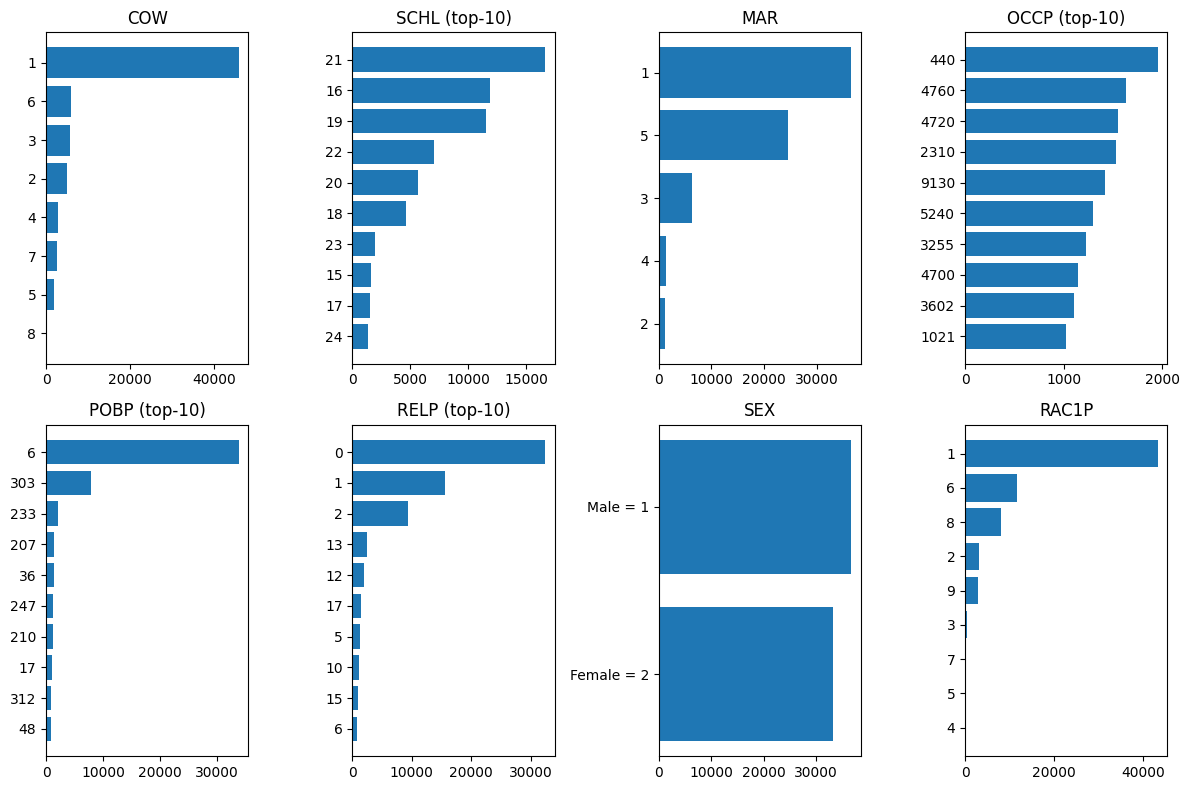

In [ ]:
#@markdown Plot distribution of categorical columns
fig, ax = plt.subplots(2,4,figsize=(12,8))
ax[0,0].barh(full_df['COW'].value_counts().index[::-1], full_df['COW'].value_counts()[::-1])
ax[0,0].set_title('COW')

ax[0,1].barh(full_df['SCHL'].value_counts().index[:10][::-1], full_df['SCHL'].value_counts()[:10][::-1])
ax[0,1].set_title('SCHL (top-10)')

ax[0,2].barh(full_df['MAR'].value_counts().index[::-1], full_df['MAR'].value_counts()[::-1])
ax[0,2].set_title('MAR')

ax[0,3].barh(full_df['OCCP'].value_counts().index[:10][::-1], full_df['OCCP'].value_counts()[:10][::-1])
ax[0,3].set_title('OCCP (top-10)')

ax[1,0].barh(full_df['POBP'].value_counts().index[:10][::-1], full_df['POBP'].value_counts()[:10][::-1])
ax[1,0].set_title('POBP (top-10)')

ax[1,1].barh(full_df['RELP'].value_counts().index[:10][::-1], full_df['RELP'].value_counts()[:10][::-1])
ax[1,1].set_title('RELP (top-10)')

ax[1,2].barh(full_df['SEX'].value_counts().index[::-1], full_df['SEX'].value_counts()[::-1])
ax[1,2].set_title('SEX')
labels = ('Female = 2', 'Male = 1')
ax[1,2].set_yticklabels(labels)

ax[1,3].barh(full_df['RAC1P'].value_counts().index[::-1], full_df['RAC1P'].value_counts()[::-1])
ax[1,3].set_title('RAC1P')

fig.tight_layout()

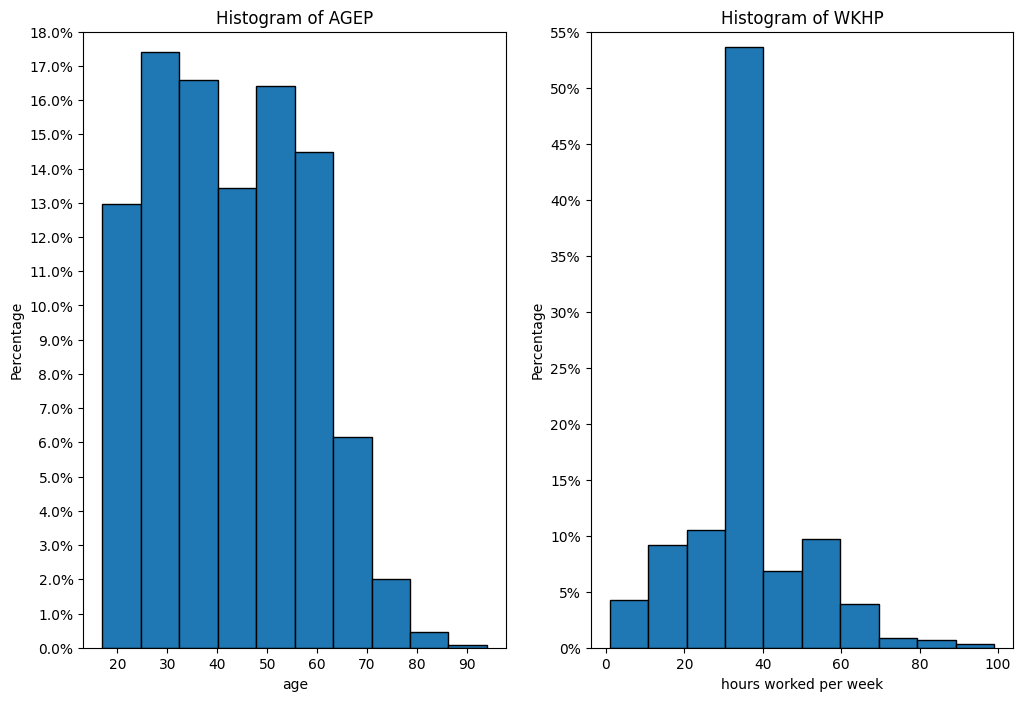

In [ ]:
#@markdown Plot distribution of numeric features
fig, ax = plt.subplots(1,2,figsize=(12,8))

#histogram for AGEP (age)
num_of_bins_agep = 10
y_vals_agep, x_vals_agep, e_agep = ax[0].hist(full_df['AGEP'], bins=num_of_bins_agep, edgecolor='black')
ax[0].set_title("Histogram of AGEP")
ax[0].set_xlabel("age")
ax[0].set_ylabel("Percentage")
y_max_agep = round((max(y_vals_agep) / len(full_df)) + 0.02, 2)
ax[0].set_yticks(ticks=np.arange(0.0, y_max_agep * len(full_df), 0.01 * len(full_df)))
ax[0].set_ylim(ax[0].get_yticks()[0], ax[0].get_yticks()[-1])
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(full_df)))

#histogram for WKHP (Hours worked per week)
num_of_bins_wkhp = 10
y_vals_wkhp, x_vals_wkhp, e_wkhp = ax[1].hist(full_df['WKHP'], bins=num_of_bins_wkhp, edgecolor='black')
ax[1].set_title("Histogram of WKHP")
ax[1].set_xlabel("hours worked per week")
ax[1].set_ylabel("Percentage")
y_max_wkhp = round((max(y_vals_wkhp) / len(full_df)) + 0.05, 2)
ax[1].set_yticks(ticks=np.arange(0.0, y_max_wkhp * len(full_df), 0.05 * len(full_df)))
ax[1].set_ylim(ax[1].get_yticks()[0], ax[1].get_yticks()[-1])
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(full_df)))

As we can see, there is nothing very unusual about the distritubtion of the features in this dataset. Also, we note that the proportion of men and women is rather balanced.

We can also examine the pairwise correlations between the numeric features and our target variable.

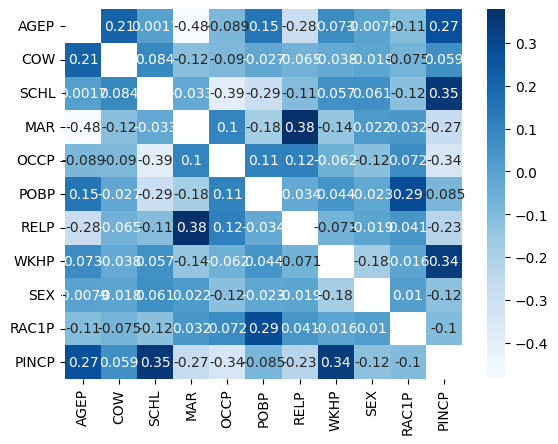

In [ ]:
#@markdown Plot pairwise correlations between numeric features

sn.heatmap(full_df.corr(), mask=np.identity(len(full_df.corr())), annot=True, cmap='Blues')
plt.show()

Here, we can see that there are only relatively low correlations between our target variable (PINCP) and our numeric features of age and hours worked per week.

Next, we can look at the distribution of our target variable as well as the joint distribution of our protected and target attributes.

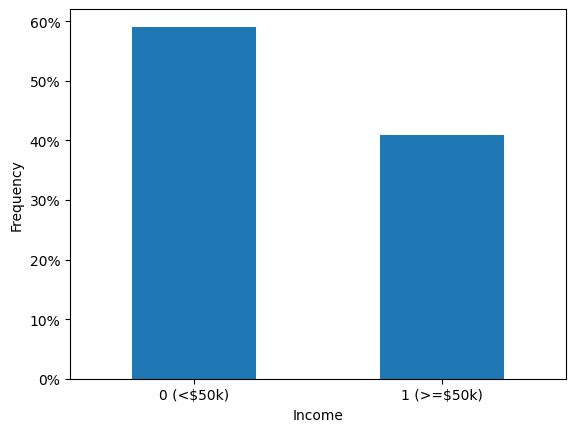

In [ ]:
#@markdown Examine distribution of target variable
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
full_df['PINCP'].value_counts().divide(full_df.shape[0]).plot(kind='bar')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
labels_target = ('0 (<$50k)', '1 (>=$50k)')
ax.set_xticklabels(labels_target)
plt.show()

From the graph above we note that there is a considerable imbalance of the target variable. Let's see how is this distribution looks by gender.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


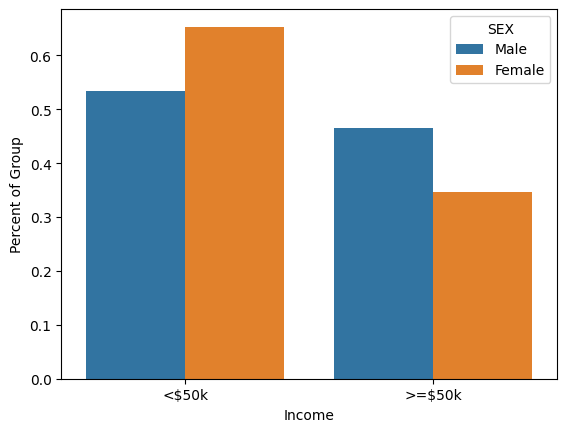

In [ ]:
#@markdown Plot distribution of target variable among males and plot distribution of target variable among females
hist_df = full_df.groupby(['SEX','PINCP']).size().to_frame('count').reset_index()
new_col = full_df.groupby(['SEX']).PINCP.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'SEX': {'1': 'Male', '2': 'Female'}}, inplace=True)
hist_df.replace({'PINCP': {0.0: '<$50k', 1.0: '>=$50k'}}, inplace=True)
sn.barplot(x='PINCP', y='frac', hue='SEX', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Income')
plt.show()

In [ ]:
#@markdown Showing the number of Males and Females per Income group
full_df.groupby(['SEX', 'PINCP'])['PINCP'].count()

SEX  PINCP
1    0.0      19624
     1.0      17113
2    0.0      21734
     1.0      11529
Name: PINCP, dtype: int64

Here, we can see that the proportion of males who make at least \$50k is higher than the proportion of females who make at least $50k in this dataset. Thus, the initial finding about imbalance of the target variable is more accentuated for females.

# **TODO**: Given the graphs above, what results might we expect from our classifier when it comes to labelling males and females as high or low income?

We may expect our classifier to be more likely to label men as high income and women as low income.

# **TODO**: Why might this data be biased? What type of bias is this?

This data is biased because it is pulled from the real world, which contains bias. For example, the real world has the wage gap which causes women to make less money than men. This is called pre-existing bias.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


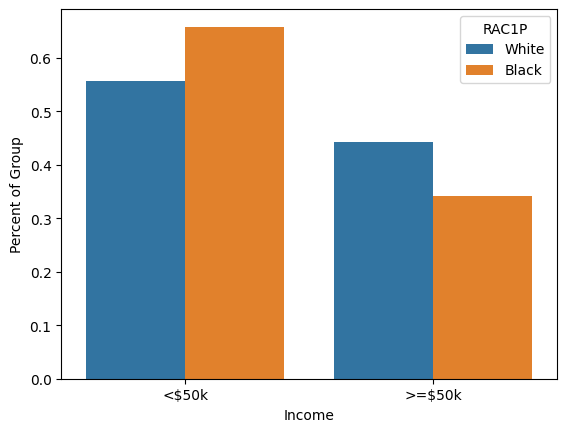

In [ ]:
# @markdown #**TODO**: write some code in this cell that replicates the above histogram plot for black and white individuals in the data.

# filter dataframe to only see race 1 or 2
filtered_df = full_df[full_df['RAC1P'].isin(['1', '2'])]

hist_df = filtered_df.groupby(['RAC1P','PINCP']).size().to_frame('count').reset_index()
new_col = filtered_df.groupby(['RAC1P']).PINCP.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'RAC1P': {'1': 'White', '2': 'Black'}}, inplace=True)
hist_df.replace({'PINCP': {0.0: '<$50k', 1.0: '>=$50k'}}, inplace=True)
sn.barplot(x='PINCP', y='frac', hue='RAC1P', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Income')
plt.show()

## Preprocessing
Next, we will do some preprocessing on our data to prepare it for use in our model.

In [ ]:
#@markdown Standardize numerical features
scaler = StandardScaler()
full_df[numerical_cols] = scaler.fit_transform(full_df[numerical_cols])
display(full_df)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,0.018381,3,18,1,2100,6,0,0.165273,2,1,0.0
1,0.889344,1,21,5,4030,39,0,-0.601203,2,2,0.0
2,-0.182610,3,24,3,2310,53,0,0.165273,2,1,1.0
3,1.157332,6,1,2,4251,303,0,0.165273,1,1,0.0
4,-0.450599,1,21,1,1541,6,1,0.931749,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
69995,1.626312,6,21,1,2360,10,0,-0.447908,1,1,0.0
69996,-0.584593,1,16,1,3603,416,0,3.231175,1,2,0.0
69997,-1.254564,4,20,5,2545,6,12,-2.134154,1,8,0.0
69998,0.487361,1,22,1,5165,17,1,4.687479,2,1,1.0


In [ ]:
#@markdown One-hot encode categorical features
full_df = pd.get_dummies(full_df, columns=categorical_cols)
display(full_df)

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,SEX_1,SEX_2
0,0.018381,0.165273,0.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,0.889344,-0.601203,0.0,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,-0.182610,0.165273,1.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1.157332,0.165273,0.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
4,-0.450599,0.931749,1.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,1.626312,-0.447908,0.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
69996,-0.584593,3.231175,0.0,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
69997,-1.254564,-2.134154,0.0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
69998,0.487361,4.687479,1.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
#@markdown Since the sex attribute is already binary we can drop one of the redundant dummy columns
#note: males are now labeled as 1 and females are labeled as 0
full_df.drop(columns=['SEX_2'], inplace=True)
full_df.rename(columns={'SEX_1':'SEX'}, inplace=True)

full_df.head()

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,SEX
0,0.018381,0.165273,0.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,0.889344,-0.601203,0.0,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,-0.182610,0.165273,1.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,1.157332,0.165273,0.0,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
4,-0.450599,0.931749,1.0,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True


#3. Train Logistic Regression Classifier
Next, we will split our data into training and test sets randomly.  Then, we will train a logistic regression classifier and evaluate possible biases within that classifier.

In [ ]:
#@markdown Split data into training and test sets
target = full_df['PINCP']
full_df.drop(columns='PINCP', inplace=True)

#note: here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent
X_train, X_test, y_train, y_test = train_test_split(full_df, target, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (56000, 808)
X_test shape: (14000, 808)
y_train shape: (56000,)
y_test shape: (14000,)


In [ ]:
#@markdown #**TODO**: What would be the accuracy rate ($\frac{(TP + TN)}{(TP + FP + TN + FN)}$) of a classifier that always predicts the majority label (baseline classifier)?
#@markdown Since the majority label is 0, the accuracy of this majority label classifier would be the number of 0's over the total number of records.
# TODO: write code here

y_test.value_counts()

baseline_accuracy = y_test.value_counts().get(0) / (y_test.value_counts().get(0) + y_test.value_counts().get(1))
print(f'General baseline accuracy: {baseline_accuracy:.4f}')

# y_test is better assessment of accuracy b/c it mimicks how the model performs on new data

General baseline accuracy: 0.5909


In [ ]:
# @markdown #**TODO**: What would be the accuracy rate ($\frac{(TP + TN)}{(TP + FP + TN + FN)}$) for the Male and Female groups considering a classifier that always predicts the majority label (baseline classifier) for each of these groups?
# write code here

# true positive = predicted majority label (0), class was 0
# true negative = predicted majority label (0), class was 1
male_zero_ct = ((X_test['SEX'] == 1) & (y_test == 0)).sum()
male_one_ct = ((X_test['SEX'] == 1) & (y_test != 0)).sum()

baseline_accuracy_male = male_zero_ct / (male_zero_ct + male_one_ct)
print(f'Male baseline accuracy: {baseline_accuracy_male:.4f}')

female_zero_ct = ((X_test['SEX'] == 0) & (y_test == 0)).sum()
female_one_ct = ((X_test['SEX'] == 0) & (y_test != 0)).sum()

baseline_accuracy_female = female_zero_ct / (female_zero_ct + female_one_ct)
print(f'Female baseline accuracy: {baseline_accuracy_female:.4f}')

Male baseline accuracy: 0.5308
Female baseline accuracy: 0.6588


In [ ]:
#@markdown Implement logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)

clear_output()

print(f'Logistic Regression test accuracy: {clf_score:.4f}')

Logistic Regression test accuracy: 0.8187


## Evaluate fairness

Next, we will evaluate the fairness of our classifier on the test set.  We will first focus on two metrics - demographic parity difference and demographic parity ratio.  Demographic parity difference is defined as the difference between the largest and the smallest group-level selection rate across all values of the sensitive feature(s).  A demographic parity difference of 0 means that all groups have the same selection rate.  Demographic parity ratio is defined as the ratio between the smallest and the largest group-level selection rate across all values of the sensitive feature(s).  A demographic parity ratio of 1 means that all groups have the same selection rate.

In Summary: let $X$ denote a feature vector used for predictions, $A$ be a single sensitive feature (such as age or race), $Y$ be the true label, and $h$ a classifier or predictor resulted from a Machine Learning algorithm. Then:

*Demographic Parity difference* is defined as $(max_a\mathbb{E}[h(X)]~|~  A = a)~ - ~ (min_a\mathbb{E}[h(X)]~|~  A = a) $


*Demographic Parity ratio* is defined as $\frac{max_a\mathbb{E}[h(X)~|~  A = a]}{min_a\mathbb{E}[h(X)~|~  A = a]} $

In [ ]:
#@markdown Evaluate the fairness of the classifier using `demographic_parity_difference` and `demographic_parity_ratio`
#note: we are conducting this analysis over the test set

#compute test predictions
y_pred = clf.predict(X_test)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Demographic parity difference: 0.1333
Demographic parity ratio: 0.7151
Male selection rate: 0.4678
Female selection rate: 0.3346


Here, we can see that there are substantial differences in selection rates between males and females with males being significantly more likely to be classified as high income.

Fairlearn also provides the fairlearn.metrics.MetricFrame class to evaluate disparities in treatment between different sub-populations.

The **fairlearn.metrics.MetricFrame** object requires a minimum of four arguments:

*   The underlying metric function(s) to be evaluated
*   The true values
*   The predicted values
*   The sensitive feature values

Metric functions must have a signature ''fn(y_true, y_pred)'', i.e., require only two arguments.  Here we will again look at selection rate, but we will also examine a few other metrics.  We will use accuracy, selection rate, false negative rate, and false positive rate.

In [ ]:
#@markdown Evaluate the fairness of the classifier using the MetricFrame class for the `SEX` variable

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature = X_test['SEX'].replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
          #  functions come from fairlearn package
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

The **fairlearn.metrics.MetricFrame** has the **overall** property, which evaluates the metrics on the entire dataset.

In [ ]:
grouped_on_sex.overall

accuracy          0.818714
selection_rate    0.405286
FNR               0.226257
FPR               0.150145
dtype: float64

## TODO: Evaluate fairness for the `RAC1P` variable, and show overall

In [ ]:
#@markdown # **TODO**: Evaluate fairness for the `RAC1P` variable (for black and white individuals at minimum), and show `grouped_on_race.overall`

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature = X_test['RAC1P_1'].replace({1:'black', 0:'non-black'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_race = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

grouped_on_race.overall

accuracy          0.818714
selection_rate    0.405286
FNR               0.226257
FPR               0.150145
dtype: float64

The **fairlearn.metrics.MetricFrame** object also has the **by_group** functionality. This displays the selected metrics evaluated on each subgroup defined by the categories in the sensitive_features (sex in our case).

In [ ]:
grouped_on_sex.by_group

,accuracy,selection_rate,FNR,FPR
SEX,,,,
False,0.826484,0.334551,0.264050,0.126617
True,0.811844,0.467833,0.201951,0.175963


In [ ]:
#@markdown # **TODO**: Display for `RAC1P` as well

grouped_on_race.by_group

,accuracy,selection_rate,FNR,FPR
RAC1P_1,,,,
False,0.827264,0.331653,0.269126,0.122153
True,0.813418,0.450896,0.205920,0.170798


Reminder: Females are labeled 0 and males are labeled 1.

<AxesSubplot:title={'center':'FNR and FPR by sex'}, xlabel='SEX'>

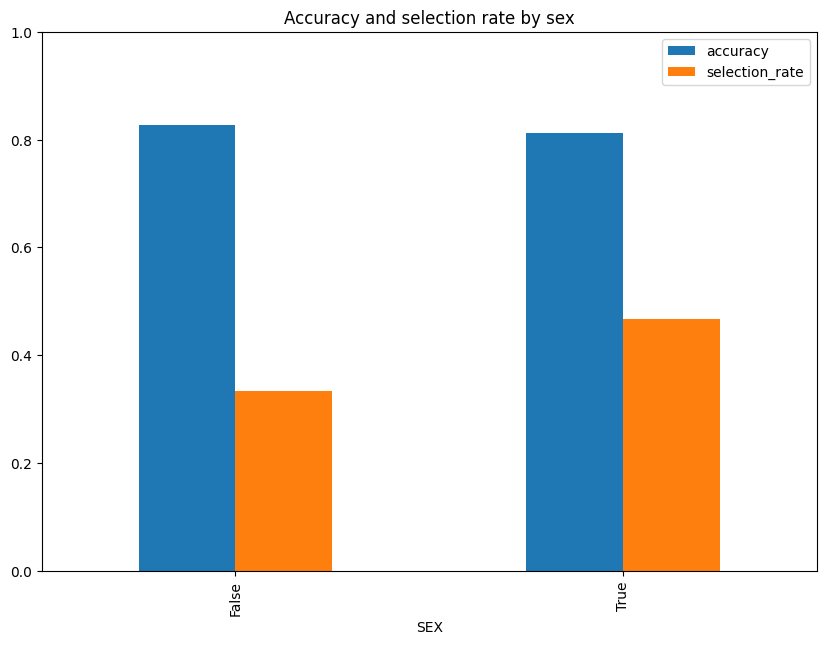

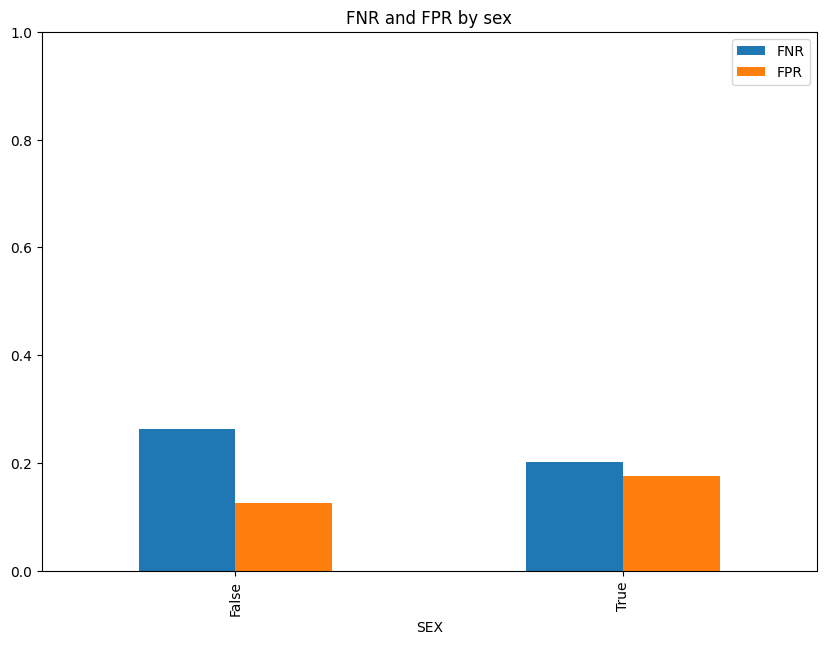

In [ ]:
#@markdown Plot the metric values

sensitive_feature = X_test['SEX'].replace({0:'female', 1:'male'})

metrics_1 = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

grouped_on_sex_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

grouped_on_sex_accuracy_selection.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by sex",
    )

grouped_on_sex_fpr_fnr.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="FNR and FPR by sex",
    )

#

<AxesSubplot:title={'center':'FNR and FPR by race'}, xlabel='RAC1P_1'>

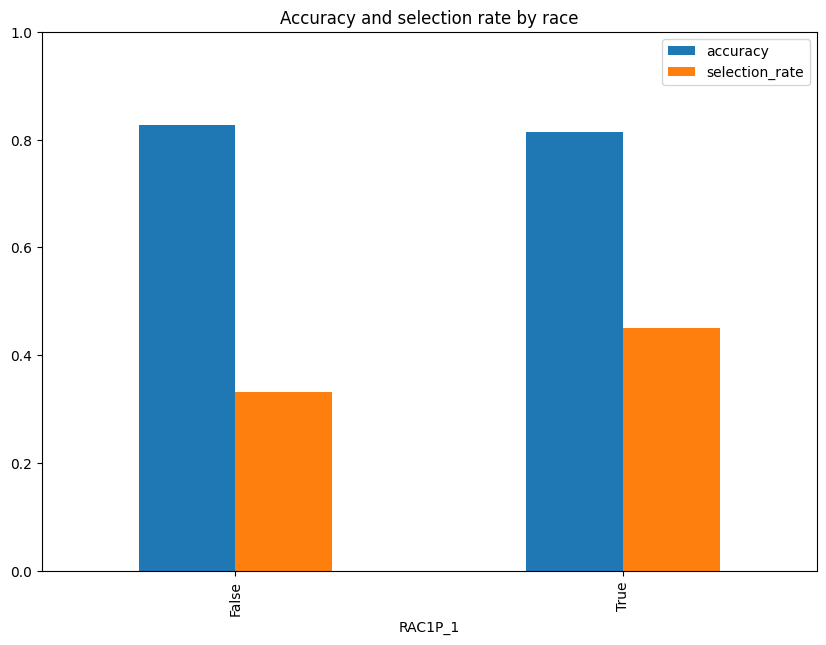

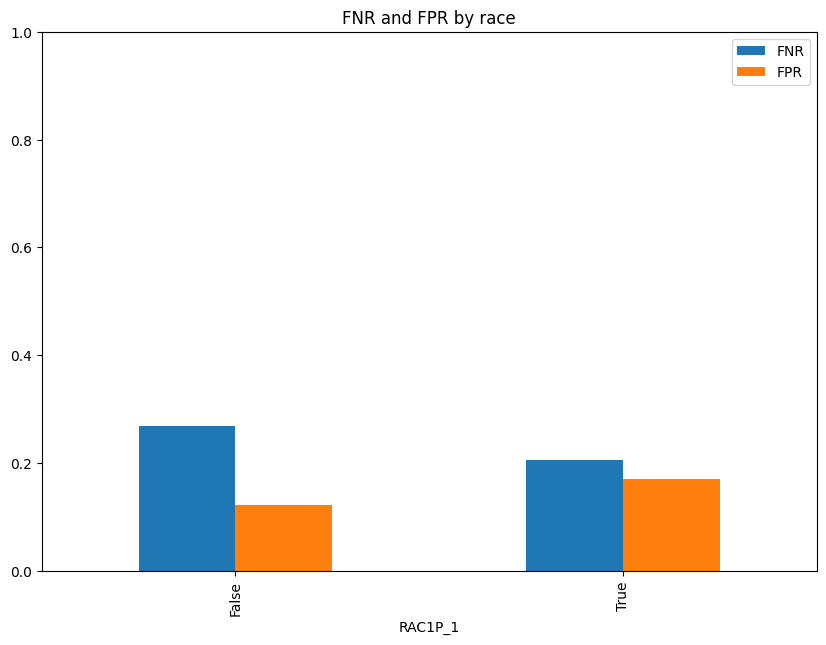

In [ ]:
# @markdown #**TODO**: Replicate the above plots for at `RAC1P` and at least black/white individuals in the data.
# write code here

#@markdown Plot the metric values

sensitive_feature = X_test['RAC1P_1'].replace({1:'black', 0:'non-black'})

metrics_1 = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_race_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

grouped_on_race_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

grouped_on_race_accuracy_selection.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by race",
    )

grouped_on_race_fpr_fnr.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="FNR and FPR by race",
    )

# **TODO**: Observe that accuracy for male and female groups is comparable, and yet we see disparities in FPR and FNR.  Which group benefits from the discrepancies in FPR and FNR shown above?  If you were deploying this system how would you measure performance (eg. accuracy, FNR, FPR)? (Reminder: females are labelled 0, males are labelled 1)

**Answer:** Women have a lower FPR than men, meaning they are less likely to be categorized as high income when they are low income. Women also have higher FNR, meaning they are more likely to be categorized as low income when they are high income. Therefore, the men are benefitting from this discrepancy.
If I were deploying this system, I would focus more on balencing FNR and FPR between the groups,  as having imbalanced FNR and FPR between sensitive groups has caused issues in last week's lab and this lab.

#4. Train "Blind" Logistic Regression Classifier (Fairness through Blindness)

Next, we will remove the protected attribute of "sex" from our data and see what effect this has on the performance of our classifier.

In [ ]:
# @markdown Remove sensitive attribute from data
X_train_blind = X_train.drop(columns='SEX')
X_test_blind = X_test.drop(columns='SEX')

In [ ]:
# @markdown Implement logistic regression

clf_blind = LogisticRegression()
clf_blind.fit(X_train_blind, y_train)
clf_blind_score = clf_blind.score(X_test_blind, y_test)

clear_output()

print(f'Logistic Regression test accuracy (without sensitive attribute): {clf_blind_score:.4f}')

Logistic Regression test accuracy (without sensitive attribute): 0.8183


In [ ]:
# @markdown Evaluate fairness of the blind classifier

#compute test predictions
y_pred_blind = clf_blind.predict(X_test_blind)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff_blind = demographic_parity_difference(y_test, y_pred_blind, sensitive_features=X_test['SEX'])
demo_parity_ratio_blind = demographic_parity_ratio(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference (without senstivie attribute): {demo_parity_diff_blind:.4f}')
print(f'Demographic parity ratio (without sensitive attribute): {demo_parity_ratio_blind:.4f}')

#compute selection rate for males and females
male_selection_rate_blind = selection_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])
female_selection_rate_blind = selection_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

print(f'Male selection rate (without sensitive attribute): {male_selection_rate_blind:.4f}')
print(f'Female selection rate (without sensitive attribute): {female_selection_rate_blind:.4f}')

Demographic parity difference (without senstivie attribute): 0.0829
Demographic parity ratio (without sensitive attribute): 0.8130
Male selection rate (without sensitive attribute): 0.4433
Female selection rate (without sensitive attribute): 0.3604


# **TODO:** describe the differences of both models in terms of accuracy and fairness among male and female groups?

The blind model is negligably less accurate than the original model. However, it is more fair as the parity difference decreased and the parity ratio increased.

**Nevertheless**, we see that removing the protected feature did not eliminate the biases within our classifier, as exhibited below.

In [ ]:
# @markdown Evaluate the biases of the classifier using the MetricFrame class
grouped_on_sex_blind = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred_blind,
                                     sensitive_features=sensitive_feature)

In [ ]:
# @markdown
grouped_on_sex_blind.overall

accuracy          0.818286
selection_rate    0.404429
FNR               0.227828
FPR               0.149782
dtype: float64

In [ ]:
# @markdown
grouped_on_sex_blind.by_group

,accuracy,selection_rate,FNR,FPR
RAC1P_1,,,,
False,0.826891,0.330532,0.271297,0.121583
True,0.812955,0.450202,0.207207,0.170588


## **Showing all the metrics for the full data and blinded data.**

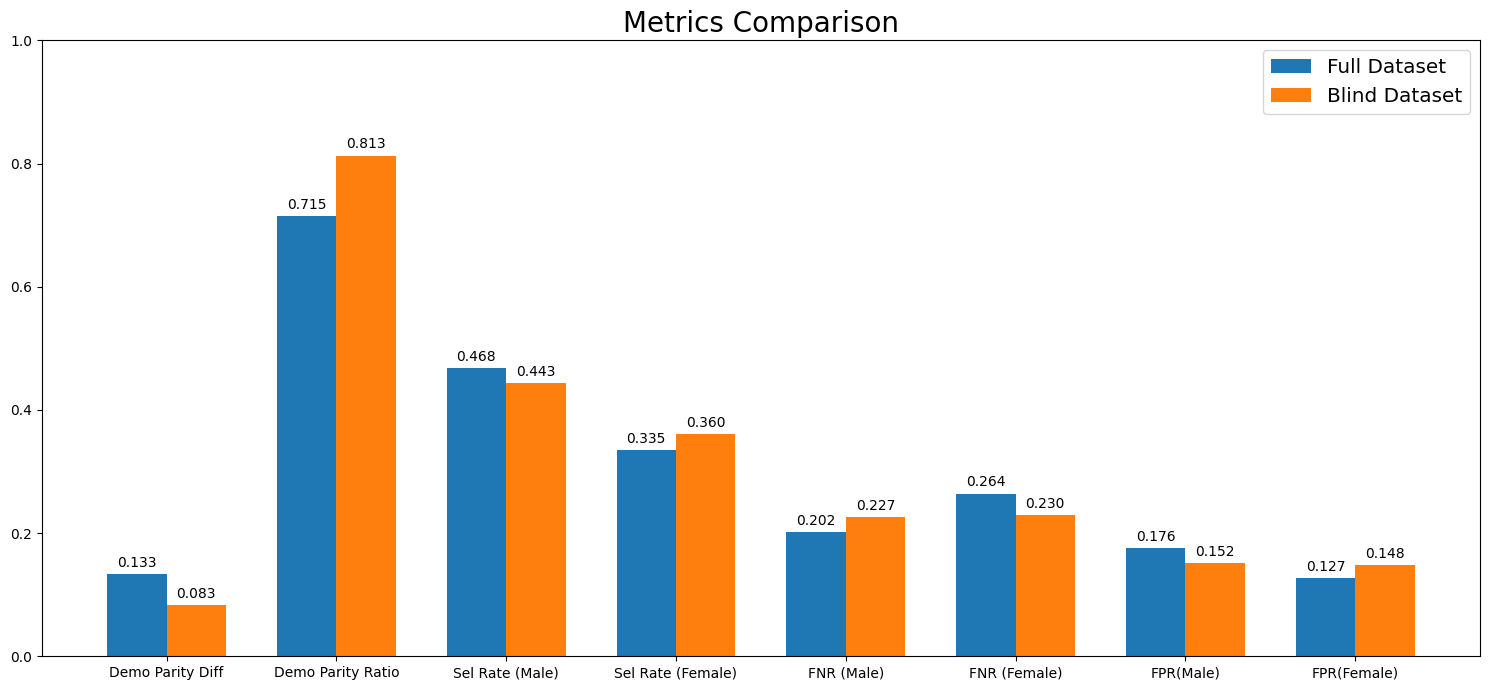

In [ ]:
# @markdown Comparing the results: full-data vs. blinded data

#demographic parity difference
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_diff_blind = demographic_parity_difference(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

#demographic parity ratio
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio_blind = demographic_parity_ratio(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

#selection rate
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_selection_rate_blind = selection_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_selection_rate_blind = selection_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#fnr
male_fnr = false_negative_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_fnr_blind = false_negative_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_fnr = false_negative_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_fnr_blind = false_negative_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#fpr
male_fpr = false_positive_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_fpr_blind = false_positive_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_fpr = false_positive_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_fpr_blind = false_positive_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#plot
labels = ['Demo Parity Diff','Demo Parity Ratio','Sel Rate (Male)',
          'Sel Rate (Female)', 'FNR (Male)', 'FNR (Female)', 'FPR(Male)',
          'FPR(Female)']

Y_full = [demo_parity_diff, demo_parity_ratio, male_selection_rate,
          female_selection_rate, male_fnr, female_fnr, male_fpr, female_fpr]

Y_blind = [demo_parity_diff_blind, demo_parity_ratio_blind,
           male_selection_rate_blind, female_selection_rate_blind, male_fnr_blind,
           female_fnr_blind, male_fpr_blind, female_fpr_blind]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.bar(x - width/2, Y_full, width, label='Full Dataset')
rects2 = ax.bar(x + width/2, Y_blind, width, label='Blind Dataset')

ax.set_title('Metrics Comparison', size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize='x-large')
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
ax.set_ylim([0, 1])
fig.tight_layout()
plt.rcParams["figure.figsize"] = (18,8)
plt.show()


# **TODO:** what are the key takeaways from this Lab?

Fairness through blindness isn't the most effective because other variables can serve as proxies for the sensitive removed variables. Thereby, the model will still be susceptible to bias.

In [ ]:
#  #**TODO:** For 10 different train/test splits, train a classifier on the full dataset as well as a classifier on a "blind" dataset (i.e. one without the sensitive attribute).  For each of these classifiers, calculate the accuracy, selection rate, false negative rate, and false positive rate by gender.  Plot your results as boxplots.  You should have 8 total subplots (i.e. a plot for each dataset (full and blind) as well as a plot for each metric).  Each plot should contain a 2 boxplots (one for males and one for females).

n = 10
sensitive_feature = X_test['SEX'].replace({0:'female', 1:'male'})

female_accuracy_full = []
female_sel_rate_full = []
female_fnr_full = []
female_fpr_full = []
male_accuracy_full = []
male_sel_rate_full = []
male_fnr_full = []
male_fpr_full = []

female_accuracy_blind = []
female_sel_rate_blind = []
female_fnr_blind = []
female_fpr_blind = []
male_accuracy_blind = []
male_sel_rate_blind = []
male_fnr_blind = []
male_fpr_blind = []

for i in range(n):
  # write code here
  X_train, X_test, y_train, y_test = train_test_split(full_df, target, test_size=0.2, random_state=i)
  clf = LogisticRegression(max_iter=1000)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  grouped_on_sex = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred,
                                     sensitive_features=sensitive_feature)
  female = grouped_on_sex.by_group.values[0]
  male = grouped_on_sex.by_group.values[1]
  female_accuracy_full.append(female[0])
  female_sel_rate_full.append(female[1])
  female_fnr_full.append(female[2])
  female_fpr_full.append(female[3])
  male_accuracy_full.append(male[0])
  male_sel_rate_full.append(male[1])
  male_fnr_full.append(male[2])
  male_fpr_full.append(male[3])

  X_train_blind = X_train.drop(columns='SEX')
  X_test_blind = X_test.drop(columns='SEX')
  clf_blind = LogisticRegression(max_iter=1000)
  clf_blind.fit(X_train_blind, y_train)
  y_pred_blind = clf_blind.predict(X_test_blind)
  grouped_on_sex_blind = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred_blind,
                                     sensitive_features=sensitive_feature)
  female = grouped_on_sex_blind.by_group.values[0]
  male = grouped_on_sex_blind.by_group.values[1]
  female_accuracy_blind.append(female[0])
  female_sel_rate_blind.append(female[1])
  female_fnr_blind.append(female[2])
  female_fpr_blind.append(female[3])
  male_accuracy_blind.append(male[0])
  male_sel_rate_blind.append(male[1])
  male_fnr_blind.append(male[2])
  male_fpr_blind.append(male[3])

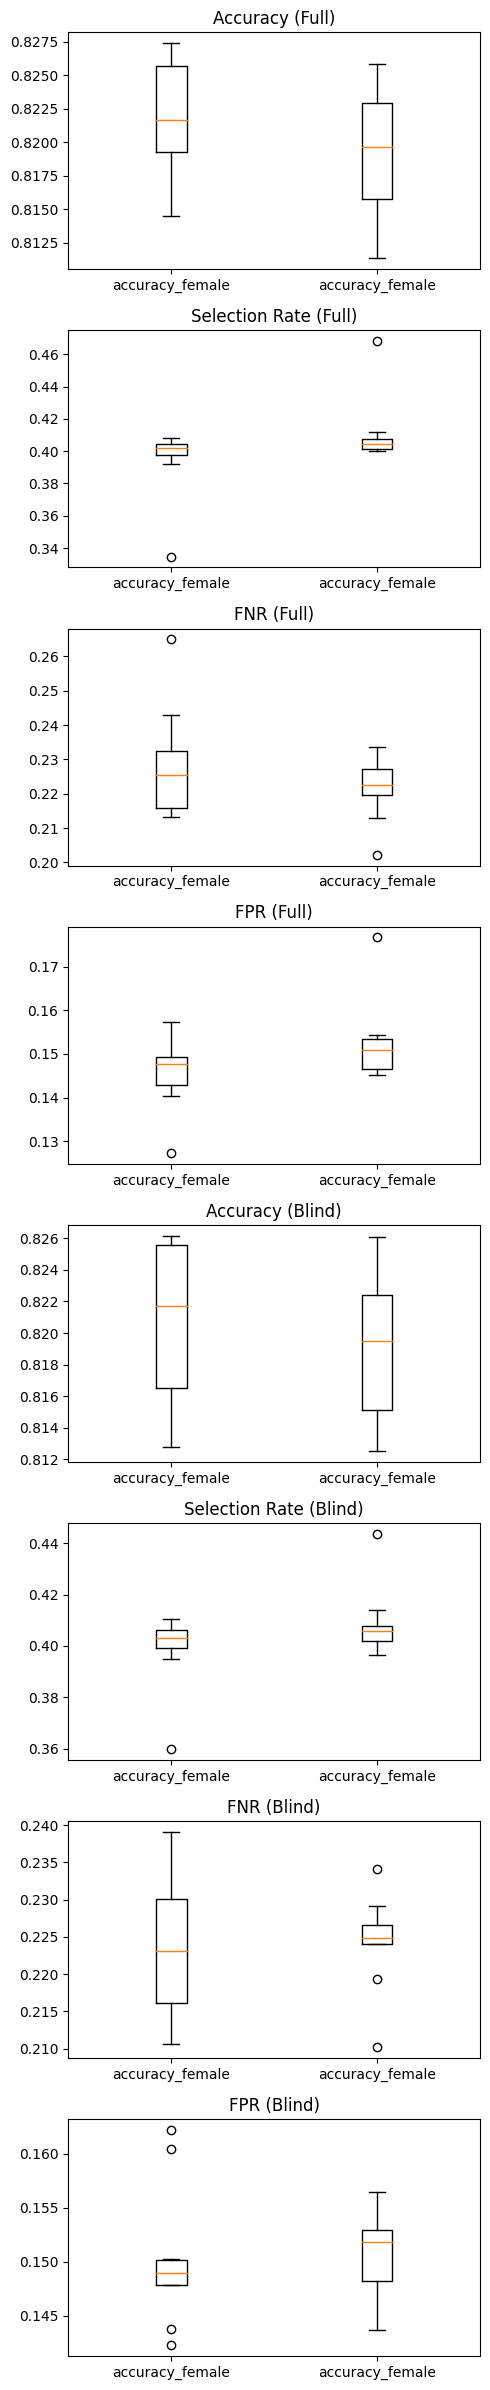

In [ ]:
## @markdown #**TODO:** Create boxplots for each metric, as shown in lab.
# write code here
title = ["Accuracy (Full)", "Selection Rate (Full)", "FNR (Full)", "FPR (Full)", "Accuracy (Blind)", "Selection Rate (Blind)", "FNR (Blind)", "FPR (Blind)",]
female_arr = [female_accuracy_full, female_sel_rate_full, female_fnr_full, female_fpr_full, female_accuracy_blind, female_sel_rate_blind, female_fnr_blind, female_fpr_blind]
male_arr = [male_accuracy_full, male_sel_rate_full, male_fnr_full, male_fpr_full, male_accuracy_blind, male_sel_rate_blind, male_fnr_blind, male_fpr_blind]

fig, axs = plt.subplots(len(title), 1, figsize=(5, 3 * len(title)))

for i in range(len(female_arr)):
  # creating plot
  bp = axs[i].boxplot(female_arr[i], positions=[1], labels=['accuracy_female'])
  bp2 = axs[i].boxplot(male_arr[i], positions=[2], labels=['accuracy_female'])
  axs[i].set_title(title[i])
# show plot
plt.tight_layout()
plt.show()



# # show plot
# plt.tight_layout()

Here, we can see our previous results replicated on multiple train/test splits. The accuracy between the classsifier trained on the full dataset and the "blind" classifier are comparable.  We also see a reduction in disparity between the selection rates, false negative rates, and false positive rates between males and females.  However, we can see that the disparities were not eliminated by removing the sensitive attribute.